# Password Strength Prediction Using NLP

***This notebook contains Modelling and Evaluation of the model.***

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Loading Data from Joblib

In [2]:
X = joblib.load('../Artifacts/X_features.pkl')
y = joblib.load('../Artifacts/y_labels.pkl')
tfidf = joblib.load('../Artifacts/tfidf_vectorizer.pkl')

## Splitting Data Into Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Baseline Model: Logistic Regression

#### Training simple logistic regression model

Explanation of Use of Parameters:

    solver='saga' -> best for high-dimensional sparse data
    n_jobs=-1 -> for using all CPU cores for performance optimization
    multi_class='multinomial' -> since we have three password strength classes

In [7]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, verbose=1, multi_class='multinomial')
log_reg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.15001991
Epoch 3, change: 0.13378089
Epoch 4, change: 0.12897932
Epoch 5, change: 0.12875
Epoch 6, change: 0.1301584
Epoch 7, change: 0.11936179
Epoch 8, change: 0.1058819
Epoch 9, change: 0.095122206
Epoch 10, change: 0.086295051
Epoch 11, change: 0.078931886
Epoch 12, change: 0.072690756
Epoch 13, change: 0.067311998
Epoch 14, change: 0.062667737
Epoch 15, change: 0.058606694
Epoch 16, change: 0.055002454
Epoch 17, change: 0.051809398
Epoch 18, change: 0.048938126
Epoch 19, change: 0.046361434
Epoch 20, change: 0.044026112
Epoch 21, change: 0.041903224
Epoch 22, change: 0.039969259
Epoch 23, change: 0.038188432
Epoch 24, change: 0.036561516
Epoch 25, change: 0.035054438
Epoch 26, change: 0.033653855
Epoch 27, change: 0.032359775
Epoch 28, change: 0.031152816
Epoch 29, change: 0.0300238
Epoch 30, change: 0.028972749
Epoch 31, change: 0.027987944
Epoch 32, change: 0.027058228
Epoch 33, change: 0.026188094
Epoch 34, change: 0.025360405
Epoch 35, cha

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=-1,
                   solver='saga', verbose=1)

#### Evaluating the baseline logistic model

In [8]:
from sklearn.metrics import accuracy_score

log_reg_y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, log_reg_y_pred)
print("Baseline Logistic Model Accuracy: ", accuracy)

Baseline Logistic Model Accuracy:  0.98135


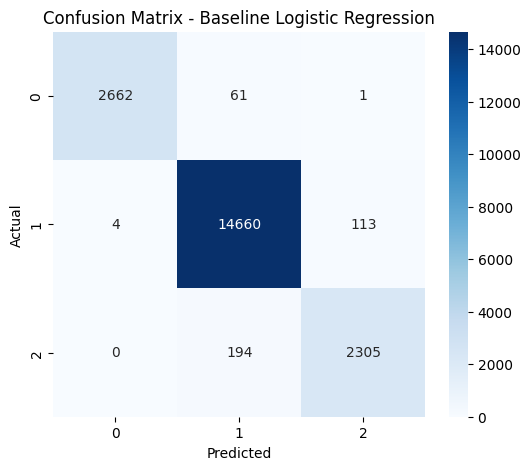

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, log_reg_y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Baseline Logistic Regression")
plt.show()

In [12]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2724
           1       0.98      0.99      0.99     14777
           2       0.95      0.92      0.94      2499

    accuracy                           0.98     20000
   macro avg       0.98      0.96      0.97     20000
weighted avg       0.98      0.98      0.98     20000



**These results are very strong for a baseline. The model achieved an accuracy of 98.1%, which is extremely high. Looking at the confusion matrix, a weak password is almost never classified as strong. It has very stable middle class and main confusion can be seen in strong vs medium, which is expected. However, this doesn't necessarily seem too good to be true because passwords are very pattern-based and the dataset is large. But it does mean that, since the baseline is already very strong, improvements will be incremental, if any.**

#### Saving the baseline logistic model

In [13]:
joblib.dump(log_reg, '../Models/baseline_logistic.pkl')

['../Models/baseline_logistic.pkl']

## Linear SVM Model